# Gromov Wasserstein



In this tutorial we show how to use a regularised approach <cite data-cite="peyre:16"></cite> to solve the Gromov-Wasserstein <cite data-cite="memoli:11"></cite> problem. The goal of the GW problem is to match points taken within different spaces endowed with their own geometries. At the core of the GW algorithm is the idea of aligning the structures of two geometries, by aligning cost matrices. We illustrate this by calculating the GW distance and the resulting transport matrix between a 2-dimensional and a 3-dimensional shape. 

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
from IPython import display
import jax
from jax import numpy as jnp
from jax import random
import numpy as np
from matplotlib import animation
from matplotlib import cm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

import ott
from ott.core import gromov_wasserstein as gw
from ott.geometry import pointcloud

## Matching between spaces with different dimensions
We apply the Gromov Wasserstein algorithm to a spiral in 2 dimensions and a Swiss roll in 3 dimensions. 

To do so, we first generate a spiral and a Swiss roll, and plot them in a 3D space. 

In [3]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


# Plots spiral and Swiss roll
def plot(
    swiss_roll, spiral, colormap_angles_swiss_roll, colormap_angles_spiral
):
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(spiral[:, 0], spiral[:, 1], c=colormap_angles_spiral)
    ax.grid()
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.view_init(7, -80)
    ax.scatter(
        swiss_roll[:, 0],
        swiss_roll[:, 1],
        swiss_roll[:, 2],
        c=colormap_angles_swiss_roll,
    )
    ax.set_adjustable("box")
    plt.show()

In [4]:
# Data parameters
n_spiral = 400
n_swiss_roll = 500
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

In [5]:
# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = random.split(key, 4)

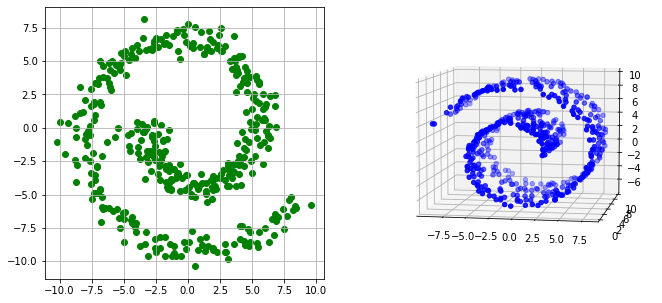

In [6]:
spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)

plot(swiss_roll, spiral, "blue", "green")

We then run OTT's Gromov-Wasserstein solver to find a matching between the points of each geometry. In this tutorial, we define two pointclouds (`ott.geometry.pointcloud.PointCloud`) but general geometries can be used as well (`ott.geometry.geometry.Geometry`). The loss between the distance matrices of the two pointclouds is by default the squared Euclidean loss.

In [7]:
# Applies Gromov Wasserstein
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
out = gw.gromov_wasserstein(
    geom_xx=geom_xx, geom_yy=geom_yy, epsilon=100.0, max_iterations=20, jit=True
)
n_outer_iterations = jnp.sum(out.costs != -1)
has_converged = bool(out.linear_convergence[n_outer_iterations - 1])
print(f"{n_outer_iterations} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularised GW cost is: {out.reg_gw_cost:.3f}")

4 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularised GW cost is: 1183.456


The resulting transport matrix between the two pointclouds is as follows:

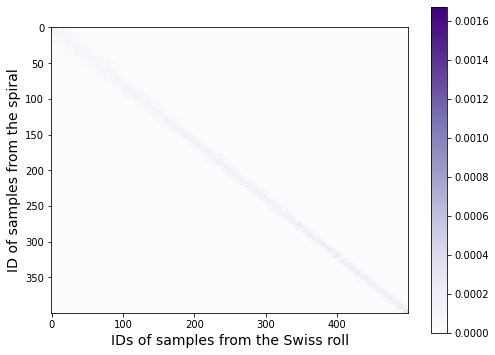

In [8]:
transport = out.matrix
fig = plt.figure(figsize=(8, 6))
plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()
plt.show()

The larger the regularisation parameter `epsilon` is, the more diffuse the transport matrix becomes, as we can see in the animation below.

In [9]:
# Animates the transport matrix
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "IDs of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()

# Initialization function
def init():
    im.set_data(np.zeros(transport.shape))
    return [im]


# Animation function
def animate(i):
    array = im.get_array()
    geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
    geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
    config = {"threshold": 1e-2}
    out = gw.gromov_wasserstein(
        geom_xx=geom_xx,
        geom_yy=geom_yy,
        epsilon=i,
        max_iterations=40,
        jit=True,
        sinkhorn_kwargs=config,
    )
    im.set_array(out.matrix)
    im.set_clim(0, jnp.max(out.matrix[:]))
    return [im]


# Call the animator
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[70.0, 100.0, 200.0, 500.0, 750.0, 1000.0, 2000.0, 10000.0, 50000.0],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

To better understand the correspondance found by the GW solver, we plot in the same color, for each point in the spiral, the point in the Swiss roll it is the most coupled to.

In [10]:
# For each sample from the spiral, we get the most coupled point from the Swiss roll
indices_swiss_roll = jnp.array(np.argmax(transport, axis=1))

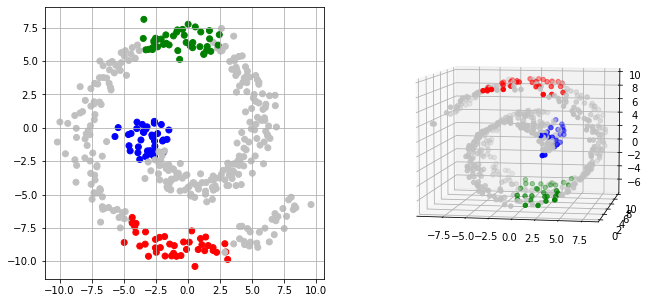

In [11]:
# Sets colors to visualise matching of some areas between each shape
# IDs of spiral and Swiss roll are ordered from center to outer part
colors_input_spiral = (
    ["b"] * 40
    + ["silver"] * 160
    + ["g"] * 40
    + ["silver"] * 90
    + ["r"] * 40
    + ["silver"] * 30
)
colors_swiss_roll = np.array(["silver"] * 500)
colors_swiss_roll[indices_swiss_roll[:40]] = "b"
colors_swiss_roll[indices_swiss_roll[200:240]] = "g"
colors_swiss_roll[indices_swiss_roll[330:370]] = "r"

plot(swiss_roll, spiral, colors_swiss_roll, colors_input_spiral)